In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as random

# import k means package

from sklearn.cluster import KMeans
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

# Import xgboost classifier
from xgboost import XGBClassifier
from xgboost import plot_tree
import xgboost as xgb
from xgboost import plot_importance
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Normalize the data attributes.
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
# Any results you write to the current directory are saved as output.

# visualize decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

import graphviz

/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/train_V2.csv


/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Read in dataset
dt = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
#dt.info()

In [3]:
# Random sample data by matchId
random.seed(3)
match_id_list = random.sample(dt["matchId"].unique().tolist(),2000)
dts = dt[dt['matchId'].isin(match_id_list)]
dts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186444 entries, 2 to 4446954
Data columns (total 29 columns):
Id                 186444 non-null object
groupId            186444 non-null object
matchId            186444 non-null object
assists            186444 non-null int64
boosts             186444 non-null int64
damageDealt        186444 non-null float64
DBNOs              186444 non-null int64
headshotKills      186444 non-null int64
heals              186444 non-null int64
killPlace          186444 non-null int64
killPoints         186444 non-null int64
kills              186444 non-null int64
killStreaks        186444 non-null int64
longestKill        186444 non-null float64
matchDuration      186444 non-null int64
matchType          186444 non-null object
maxPlace           186444 non-null int64
numGroups          186444 non-null int64
rankPoints         186444 non-null int64
revives            186444 non-null int64
rideDistance       186444 non-null float64
roadKills        

In [4]:
# Collapse fpp and tpp match type. Only classify match type by single, dual, squad and event.
# Only take match type of our intrest, that is squad
def match_3(row):
    if 'solo' in row['matchType']:
        return 'solo'
    elif 'duo' in row['matchType']: 
        return 'duo'
    elif 'squad' in row['matchType']:
        return 'squad'
    else:
        return 'event'

dts['gameMode'] = dts.apply(lambda row: match_3(row), axis=1)
dts = dts.loc[dts['gameMode'] == 'squad']
dts.shape

# fpp variable
# Should we include fpp variable even if it not used as any measurement variable in SEM?
def fpp_gen(row):
    if 'fpp' in row['matchType']:
        return 'yes'
    elif 'fpp' not in row['matchType']:
        return 'no'
dts['fpp'] = dts.apply(lambda row: fpp_gen(row), axis=1)

# Count number of players joined in one match
#players joined
dts['playersJoined']=dts.groupby('matchId')['matchId'].transform('count')
dts[['playersJoined', 'matchId']].head()
dts=dts[dts['playersJoined']>=85]
len(dts)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


98351

In [5]:
# Merge winpoint and rankpoint
#‘winPoints’ and ‘rankPoints’
def merge_ranking(row):
    return max(row['rankPoints'], row['winPoints'])

dts['newRank'] = dts.apply(lambda row: max(row['rankPoints'], row['winPoints']), axis=1)
dts['newRank'].isna().sum()
dts=dts.drop(columns=['rankPoints', 'winPoints'])

# headshot rate
def replace_nan(row):
    if np.isnan(row['headshotRate']):
        return 0
    else:
        return row['headshotRate']
    
dts["headshotRate"]=dts["headshotKills"]/dts["kills"]
dts['headshotRate'] = dts.apply(lambda row: replace_nan(row), axis=1)



In [6]:
# Select variable of interest.

attack_var = ['damageDealt', 'DBNOs', 'kills', 
              'killStreaks', 'longestKill', 'headshotRate']

support_var = ['boosts', 'heals', 'weaponsAcquired']

coop_var = ['assists', 'revives', 'teamKills']

mov_var = ['rideDistance', 'swimDistance', 'walkDistance']



In [7]:


def optimal_cluster_num(latent, normalized_X):
    
    # Function show elbow plot for different cluster number options. 
    # (default 1 - 10 clusters)
    
    distortions = []
    for i in range(1, 11):
        t0 = time()
        km = KMeans(
            n_clusters = i, init = 'random', 
            n_init=10, max_iter=300, 
            tol=1e-04, random_state=0)
        km.fit(normalized_X)
        distortions.append(km.inertia_)
        print('number of cluster = ' + str(i))
        print('Time: ' + str(time() - t0))

    plt.plot(range(1, 11), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()  
    
    return 0


In [8]:
def kmeans_output(num_class, normalized_X, var):
    
    # Create mean for each cluster, each variable
    
    km = KMeans(
        n_clusters = num_class, init = 'random', 
        n_init=10, max_iter=300, 
    tol=1e-04, random_state=0)

    normalized_X['class'] = km.fit_predict(normalized_X)
    
    
    prediction = pd.DataFrame(normalized_X)
    prediction.columns = var + ['class']
    
    features = pd.DataFrame([])
    for i in range(0, num_class):
        temp = pd.DataFrame(prediction[prediction['class'] == i].describe())
        temp = pd.DataFrame(temp.loc['mean', :])
        temp.columns = ['class' + str(i)]
        features = pd.concat([features, temp], axis=1)
        
    return features


In [9]:
def get_prediction(normalized_X, num_class):
    km = KMeans(
        n_clusters = num_class, init = 'random', 
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0)
    return km.fit_predict(normalized_X)

number of cluster = 1
Time: 0.2960681915283203
number of cluster = 2
Time: 0.6641602516174316
number of cluster = 3
Time: 0.7305953502655029
number of cluster = 4
Time: 1.583592176437378
number of cluster = 5
Time: 1.568716049194336
number of cluster = 6
Time: 2.5502350330352783
number of cluster = 7
Time: 3.4493842124938965
number of cluster = 8
Time: 3.8349504470825195
number of cluster = 9
Time: 5.411243438720703
number of cluster = 10
Time: 5.351698398590088


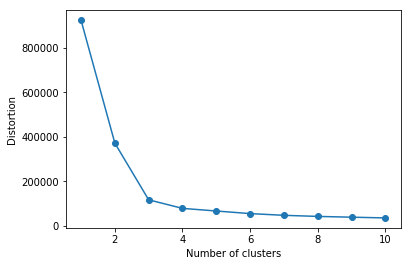

,class0,class1,class2
damageDealt,5.333131,0.029798,4.256267
DBNOs,0.949603,0.018254,0.248483
kills,1.074944,0.005368,0.082689
killStreaks,0.815611,0.005292,0.081558
longestKill,3.575264,0.020488,0.150318
headshotRate,0.180175,0.000708,0.017714
class,0.000000,1.000000,2.000000


In [10]:
 
# Normalize attack ability variables
selected = attack_var

X = dts[selected]

X.reset_index(drop=True)

transformer = FunctionTransformer(np.log1p, validate=True)

normalized_X = transformer.transform(X)

normalized_X = pd.DataFrame(normalized_X)
normalized_X.columns = selected

# Show class number plot
optimal_cluster_num(selected, normalized_X)

# create final output
features = kmeans_output(3, normalized_X, selected)

attack_class = get_prediction(normalized_X, 3)
features

number of cluster = 1
Time: 0.2502589225769043
number of cluster = 2
Time: 0.5438389778137207
number of cluster = 3
Time: 0.7662904262542725
number of cluster = 4
Time: 1.1432397365570068
number of cluster = 5
Time: 1.1605007648468018
number of cluster = 6
Time: 1.2847788333892822
number of cluster = 7
Time: 1.944718599319458
number of cluster = 8
Time: 2.0064034461975098
number of cluster = 9
Time: 2.502049207687378
number of cluster = 10
Time: 2.736647367477417


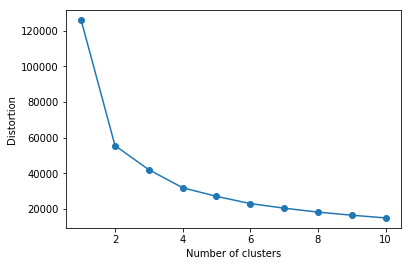

,class0,class1,class2,class3
boosts,1.125622,1.253900,0.033110,0.099071
heals,0.684572,1.868939,0.052502,0.127226
weaponsAcquired,1.706909,1.755756,0.773173,1.645883
class,0.000000,1.000000,2.000000,3.000000


In [11]:
# Normalize support ability variables
selected = support_var

X = dts[selected]

X.reset_index(drop=True)

transformer = FunctionTransformer(np.log1p, validate=True)

normalized_X = transformer.transform(X)

normalized_X = pd.DataFrame(normalized_X)
normalized_X.columns = selected

# Show class number plot
optimal_cluster_num(selected, normalized_X)

# create final output
features = kmeans_output(4, normalized_X, selected)

support_class = get_prediction(normalized_X, 4)

features

number of cluster = 1
Time: 0.2612152099609375
number of cluster = 2
Time: 0.3684210777282715
number of cluster = 3
Time: 0.5719189643859863
number of cluster = 4
Time: 0.6423957347869873
number of cluster = 5
Time: 0.7562267780303955
number of cluster = 6
Time: 0.9368603229522705
number of cluster = 7
Time: 0.9680452346801758
number of cluster = 8
Time: 0.9806618690490723
number of cluster = 9
Time: 1.3409655094146729
number of cluster = 10
Time: 1.6730313301086426


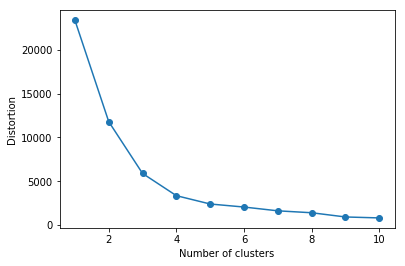

,class0,class1,class2,class3
assists,0.000000,0.000000,0.808323,0.869158
revives,0.000000,0.783754,0.000000,0.818289
teamKills,0.017716,0.030912,0.017594,0.021886
class,0.000000,1.000000,2.000000,3.000000


In [12]:
# Normalize cooperation ability variables
selected = coop_var

X = dts[selected]

X.reset_index(drop=True)

transformer = FunctionTransformer(np.log1p, validate=True)

normalized_X = transformer.transform(X)

normalized_X = pd.DataFrame(normalized_X)
normalized_X.columns = selected

# Show class number plot
optimal_cluster_num(selected, normalized_X)

# create final output
features = kmeans_output(4, normalized_X, selected)

coop_class = get_prediction(normalized_X, 4)

features

number of cluster = 1
Time: 0.25423479080200195
number of cluster = 2
Time: 0.7880923748016357
number of cluster = 3
Time: 0.9142510890960693
number of cluster = 4
Time: 1.8906540870666504
number of cluster = 5
Time: 2.2687079906463623
number of cluster = 6
Time: 3.8422889709472656
number of cluster = 7
Time: 4.4758782386779785
number of cluster = 8
Time: 5.526989459991455
number of cluster = 9
Time: 8.548445701599121
number of cluster = 10
Time: 9.37773609161377


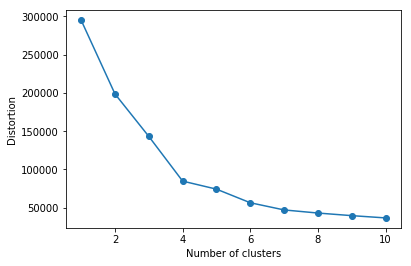

,class0,class1,class2,class3
rideDistance,2.641611,-0.135805,0.431497,-0.359925
swimDistance,-0.051686,0.056648,8.176149,-0.143125
walkDistance,0.724499,1.186467,1.127004,-0.675140
class,0.000000,1.000000,2.000000,3.000000


In [13]:
# Normalize mobility variables
selected = mov_var

X = dts[selected]

X.reset_index(drop=True)

normalized_X = preprocessing.scale(X)

normalized_X = pd.DataFrame(normalized_X)
normalized_X.columns = selected

# Show class number plot
optimal_cluster_num(selected, normalized_X)

# create final output
features = kmeans_output(4, normalized_X, selected)

mov_class = get_prediction(normalized_X, 4)

features

In [14]:
temp = pd.DataFrame(dts['winPlacePerc']).reset_index(drop=True)
attack_class_dt = pd.DataFrame({'attack_class': attack_class})
support_class_dt = pd.DataFrame({'support_class': support_class})
coop_class_dt = pd.DataFrame({'coop_class': coop_class})
mov_class_dt = pd.DataFrame({'mov_class': mov_class})

X_dt = pd.concat([temp, attack_class_dt, support_class_dt, coop_class_dt, mov_class_dt], axis=1)

def binary_win(row):
    if (row['winPlacePerc'] > 0.9):
        return 1
    else:
        return 0

X_dt['win'] = X_dt.apply(lambda row: binary_win(row), axis=1)   
X_dt.head()

,winPlacePerc,attack_class,support_class,coop_class,mov_class,win
0,0.4231,2,1,0,2,0
1,0.6800,1,1,0,0,0
2,0.1538,0,0,0,2,0
3,0.2963,2,1,0,2,0
4,0.1786,2,2,2,2,0


In [15]:
# One hot encoder latent classes

enc = OneHotEncoder(handle_unknown='ignore', sparse = False)

feature_col = ['attack_class', 'support_class', 'coop_class', 'mov_class']

X_init = X_dt[feature_col]

enc.fit(X_init)

X = pd.DataFrame(enc.transform(X_init))
X.columns = enc.get_feature_names(feature_col)
print(X.shape)
print(X.columns)
X.head()

alternative_names = ['All-round_attacker', 'Weak_attacker', 'Damage_dealer',
                     'Moderate_self-supporter', 'All-round_self-supporter', 'Weak_self-supporter', 'Weapon_collector',
                     'Weak_assistant','Supporting_assistant', 'Attacking_assistant', 'All-round_assistants',
                     'Driver', 'Walker', 'Swimmer', 'Weak_mover']
print(alternative_names)
X.columns = alternative_names
X.head()

(98351, 15)
Index(['attack_class_0', 'attack_class_1', 'attack_class_2', 'support_class_0',
       'support_class_1', 'support_class_2', 'support_class_3', 'coop_class_0',
       'coop_class_1', 'coop_class_2', 'coop_class_3', 'mov_class_0',
       'mov_class_1', 'mov_class_2', 'mov_class_3'],
      dtype='object')
['All-round_attacker', 'Weak_attacker', 'Damage_dealer', 'Moderate_self-supporter', 'All-round_self-supporter', 'Weak_self-supporter', 'Weapon_collector', 'Weak_assistant', 'Supporting_assistant', 'Attacking_assistant', 'All-round_assistants', 'Driver', 'Walker', 'Swimmer', 'Weak_mover']


,All-round_attacker,Weak_attacker,Damage_dealer,Moderate_self-supporter,All-round_self-supporter,Weak_self-supporter,Weapon_collector,Weak_assistant,Supporting_assistant,Attacking_assistant,All-round_assistants,Driver,Walker,Swimmer,Weak_mover
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Train test split
y = X_dt.win

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [17]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8958516911814546


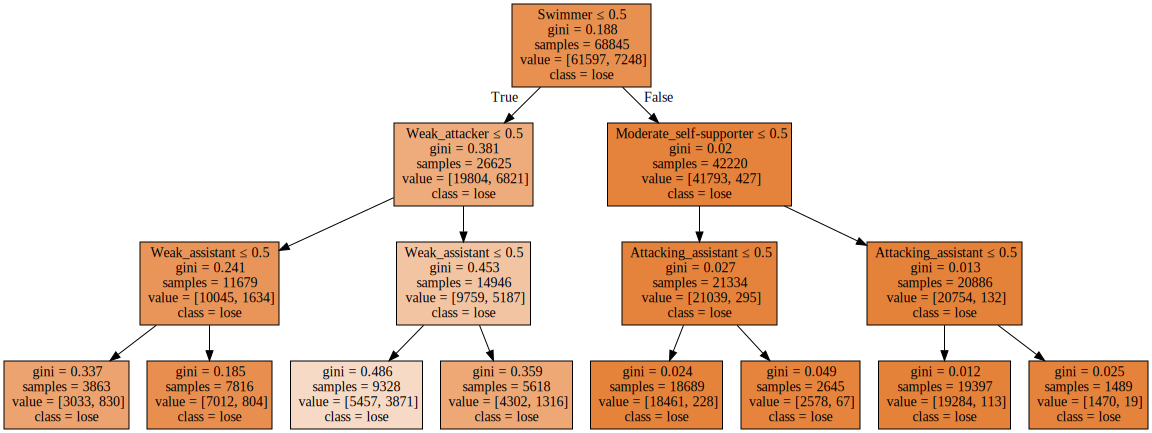

In [18]:
# Visualize decision tree
data = export_graphviz(clf,out_file=None,feature_names=X.columns,class_names=['lose', 'win'],   
                         filled=True, rounded=False,  
                         special_characters=True)
graph = graphviz.Source(data)
graph

[0]	train-auc:0.876719


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-auc:0.879979
[99]	train-auc:0.881149
AUC: 0.8797
ACC: 0.7498
Recall: 0.9092
F1-score: 0.4309
Precesion: 0.2823
Sensitivity: 0.9092
[[19331  7102]
 [  279  2794]]


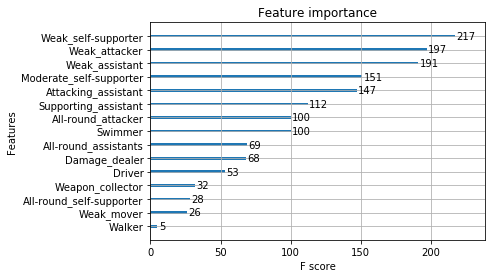

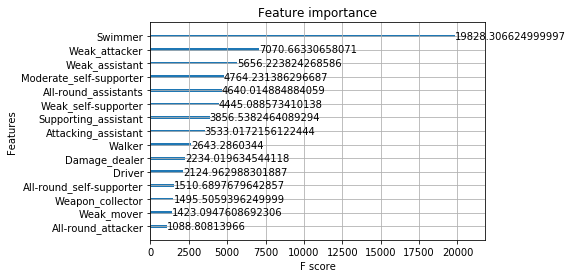

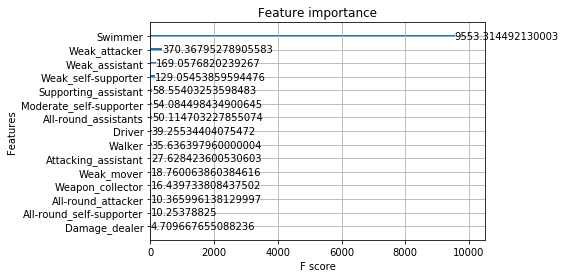

In [19]:
# Use xgboost to make prediction

params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':0.3,
    'subsample':0.8,
    'max_delta_step': 5,
    'scale_pos_weight': 9,
    'colsample_bytree':1,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0, 
    'verbosity': 0}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

watchlist = [(dtrain,'train')]
bst=xgb.train(params, dtrain ,num_boost_round=100,evals=watchlist, verbose_eval=50)


# Make prediction.
ypred=bst.predict(dtest)

# Set prediction threshold, greated than 0.5 is contact.
y_pred = (ypred >= 0.5)*1

# Print performance metrix
print ('AUC: %.4f' % metrics.roc_auc_score(y_test,ypred))
print ('ACC: %.4f' % metrics.accuracy_score(y_test,y_pred))
print ('Recall: %.4f' % metrics.recall_score(y_test,y_pred))
print ('F1-score: %.4f' %metrics.f1_score(y_test,y_pred))
print ('Precesion: %.4f' %metrics.precision_score(y_test,y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print ('Sensitivity: %.4f' %(tp/(tp+fn)))
print(metrics.confusion_matrix(y_test,y_pred))

plot_importance(bst, importance_type = 'weight')
plt.show()

plot_importance(bst, importance_type = 'cover')
plt.show()

plot_importance(bst, importance_type = 'gain')
plt.show()




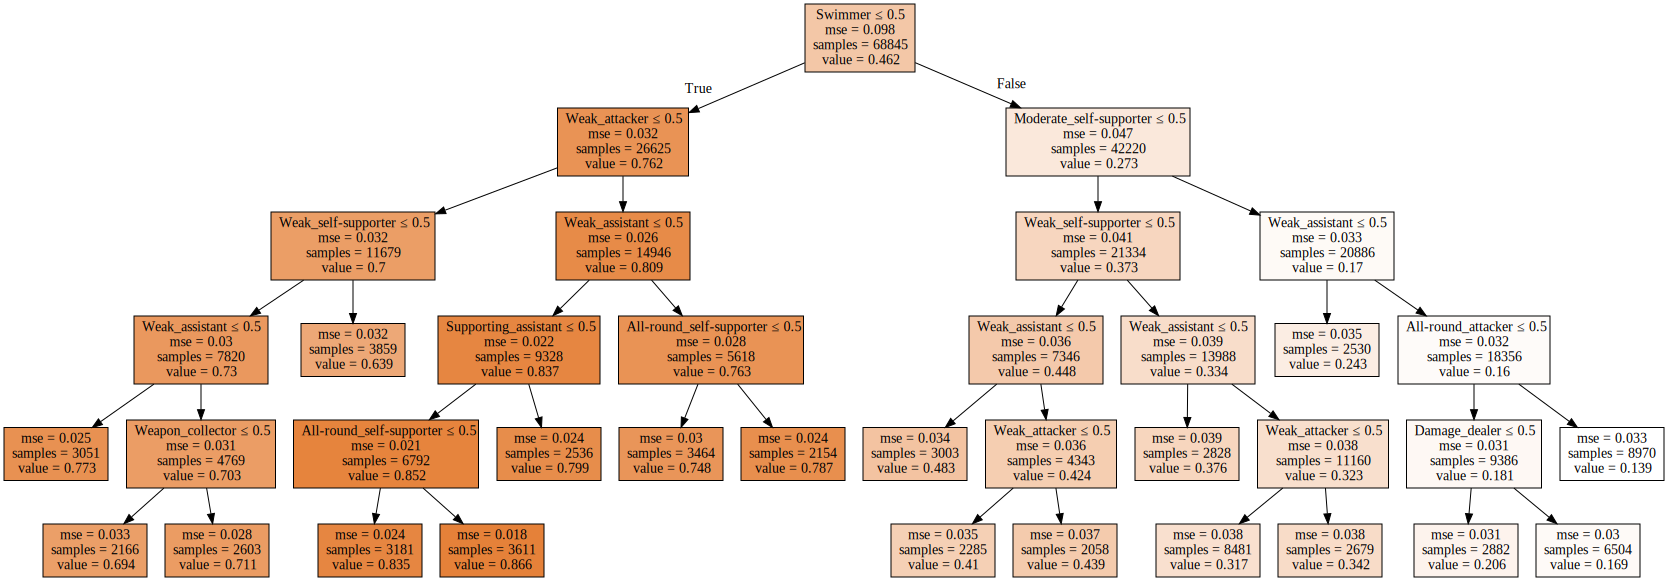

In [20]:
# Regression Tree data
y_2 = X_dt.winPlacePerc
X_train, X_test, y_train, y_test = train_test_split(X, y_2, test_size=0.3, random_state=1)

rgt_1 = DecisionTreeRegressor(max_depth=5, min_samples_leaf = 2000)
rgt_1.fit(X_train, y_train)

# Visualize regression tree
data = export_graphviz(rgt_1,out_file=None,feature_names=X.columns,   
                         filled=True, rounded=False,  
                         special_characters=True)
graph = graphviz.Source(data)
graph

In [21]:
export_graphviz(rgt_1, out_file='whole_tree.dot', feature_names = X_train.columns,
                rounded = True, proportion = False, precision = 2, filled = True, max_depth = 5)

In [22]:
!dot -Tpng whole_tree.dot -o whole_tree.png -Gdpi=600

In [23]:
rgt_importance = dict(zip(X_train.columns, rgt_1.feature_importances_))
pd.DataFrame([rgt_importance]).transpose().sort_values(by = 0, ascending = False)

,0
Swimmer,0.852577
Moderate_self-supporter,0.094763
Weak_self-supporter,0.018509
Weak_attacker,0.017558
Weak_assistant,0.012254
All-round_attacker,0.001748
Supporting_assistant,0.001121
All-round_self-supporter,0.000800
Damage_dealer,0.000598
Weapon_collector,0.000072


In [24]:
# Among winners (win percentage over 0.9), what type of players have higher proability to win?

X_win = X_dt[X_dt['win']==1]




In [25]:
# One hot encoder latent classes

enc = OneHotEncoder(handle_unknown='ignore', sparse = False)

feature_col = ['attack_class', 'support_class', 'coop_class', 'mov_class']

X_init = X_win[feature_col]

enc.fit(X_init)

X = pd.DataFrame(enc.transform(X_init))
X.columns = enc.get_feature_names(feature_col)
print(X.shape)
X.columns = alternative_names
X.head()


(10321, 15)


,All-round_attacker,Weak_attacker,Damage_dealer,Moderate_self-supporter,All-round_self-supporter,Weak_self-supporter,Weapon_collector,Weak_assistant,Supporting_assistant,Attacking_assistant,All-round_assistants,Driver,Walker,Swimmer,Weak_mover
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [26]:
# Regression Tree data

y_win = X_win.winPlacePerc
X_train, X_test, y_train, y_test = train_test_split(X, y_win, test_size=0.3, random_state=1)


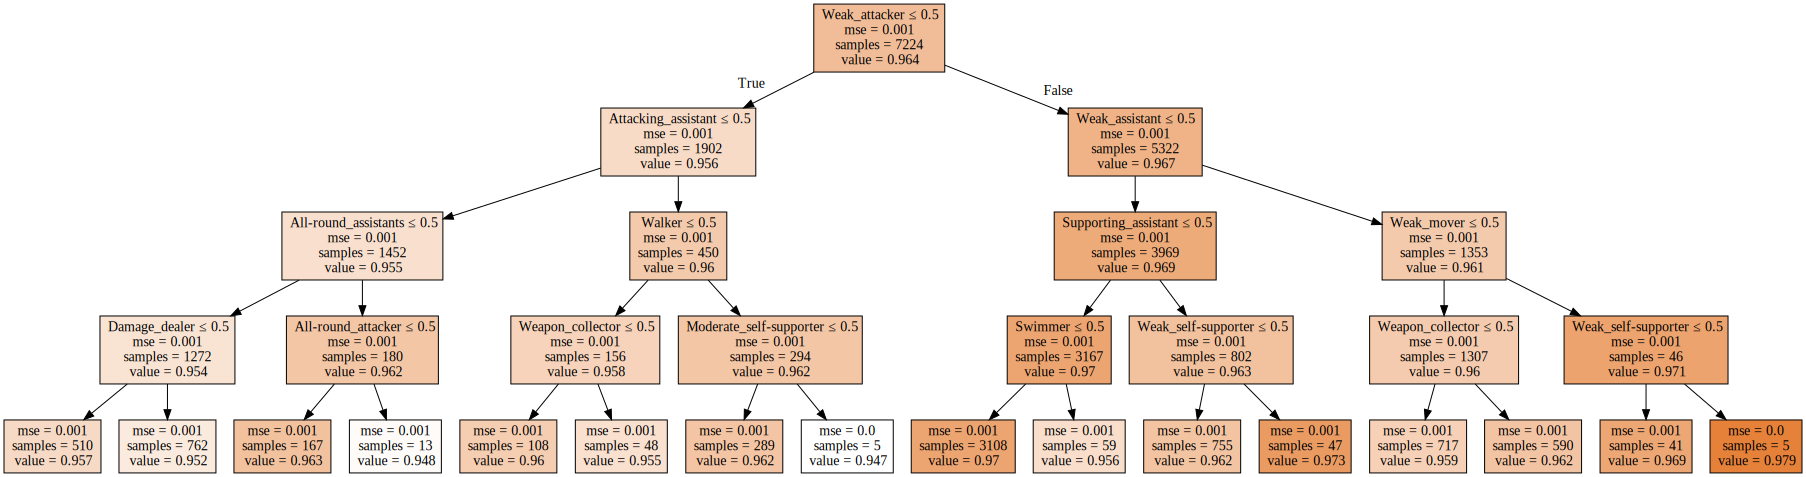

In [27]:

rgt = DecisionTreeRegressor(max_depth=4)
rgt.fit(X_train, y_train)

# Visualize regression tree
data = export_graphviz(rgt,out_file=None,feature_names=X.columns,   
                         filled=True, rounded=False,  
                         special_characters=True)
graph = graphviz.Source(data)
graph

In [28]:
export_graphviz(rgt, out_file='winner_tree.dot', feature_names = X_train.columns,
                rounded = True, proportion = False, precision = 2, filled = True, max_depth = 4)

In [29]:
!dot -Tpng winner_tree.dot -o winner_tree.png -Gdpi=600

In [30]:
rgt_importance = dict(zip(X_train.columns, rgt.feature_importances_))
pd.DataFrame([rgt_importance]).transpose().sort_values(by = 0, ascending = False)

,0
Weak_attacker,0.487191
Weak_assistant,0.213776
Supporting_assistant,0.112079
Swimmer,0.042276
Attacking_assistant,0.034176
All-round_assistants,0.029329
Damage_dealer,0.017327
Weak_self-supporter,0.017292
Weak_mover,0.015794
Weapon_collector,0.014861
